In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import RMSprop
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [0]:
os.chdir('/content/gdrive/My Drive/thesis')

In [0]:
data = pd.read_pickle('master_dataset_24112019.pkl')



In [0]:
target = pd.DataFrame()
target['1_h'] = data['dk2'].shift(-1)
target['24_h'] = data['dk2'].shift(-24)
features = data.iloc[0: -24, :]

In [0]:
target = target[:-24]

In [0]:
target_fitter = target

In [0]:
imp_mean2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


In [0]:
imp_mean2.fit(target_fitter)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [0]:
imp_target = imp_mean2.transform(target_fitter)

In [0]:
qs = [-100]
for i in range(1, 101):
  q = i
  qs.append(np.percentile(imp_target, q))

In [0]:
new_feature = features['dk2'].copy()

In [0]:
new_feature = pd.DataFrame(new_feature, index=target.index)
new_feature.columns = ['price']

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
def is_in_range(x, lower, upper, val):
  if lower < x <= upper:
    return val
  else:
    return 0

In [0]:
ss = dict()
for i, (lower, upper) in enumerate(zip(qs[:-1], qs[1:])):
  print(lower, upper)
  s = new_feature['price'].apply(lambda row: is_in_range(row, lower, upper, i))
  ss[i] = s

-100 23.524999999999995
23.524999999999995 57.2
57.2 72.60899999999997
72.60899999999997 84.75
84.75 97.36499999999998
97.36499999999998 111.72
111.72 122.9435
122.9435 133.65
133.65 141.76349999999996
141.76349999999996 148.17
148.17 152.6155
152.6155 157.26
157.26 161.58650000000003
161.58650000000003 165.27
165.27 169.20749999999998
169.20749999999998 173.26
173.26 176.8
176.8 179.71
179.71 182.82950000000002
182.82950000000002 185.62
185.62 187.79
187.79 190.72199999999998
190.72199999999998 193.65
193.65 196.21000000000004
196.21000000000004 199.26
199.26 201.71300000000002
201.71300000000002 204.7
204.7 207.45
207.45 209.53
209.53 211.86
211.86 214.13
214.13 216.036
216.036 217.85
217.85 219.73
219.73 221.54
221.54 223.22999999999996
223.22999999999996 224.68
224.68 226.45
226.45 228.38
228.38 230.04
230.04 231.54049999999992
231.54049999999992 233.53
233.53 235.31
235.31 237.26
237.26 238.83
238.83 240.57
240.57 242.58000000000004
242.58000000000004 244.63
244.63 246.25
246.25 2

In [0]:
_df = pd.DataFrame(ss)

In [0]:
features['price_bin'] = _df.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
features['price_bin'] = _df.sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
#features.to_pickle('master_dataset_15112019.pkl')

In [0]:
imp_mean1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean1.fit(features)
imp_features = imp_mean1.transform(features)

In [0]:
train_split = 0.9
num_train = int(train_split * len(features))
num_test = len(features) - num_train

In [0]:
x_train = features.iloc[0:num_train , :]
x_test = features.iloc[num_train+1: , :]

try:
  y_train = target.iloc[0:num_train , :]
  y_test = target.iloc[num_train+1: , :]
except:
  y_train = target_fitter[0:num_train]
  y_test = target_fitter[num_train+1:]

In [0]:
x_train = imp_mean1.transform(x_train)
x_test = imp_mean1.transform(x_test)

y_train = imp_mean2.transform(y_train)
y_test = imp_mean2.transform(y_test)

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training data
    """
    
    num_x_signals = features.shape[1]
    num_y_signals = 2
    
    # infinite loop
    while True:
        # Allocate a new array for the batch of input signals
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        
        # Allocate a new array for the batch of output signals 
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        # Fill the batch with random sequences of data
        for i in range(batch_size):
            # Get a random start_index
            # This points somewhere in the training data
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequence of data starting from this index
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
            
        yield (x_batch, y_batch)

In [0]:
batch_size = 256
sequence_length = 24 * 7 * 8

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [0]:
x_batch.shape ,y_batch.shape

((256, 1344, 34), (256, 1344, 2))

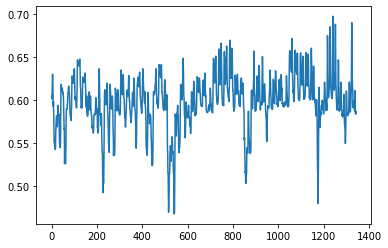

In [0]:
batch = 0 
signal = 0
seq = x_batch[batch , : , signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
MODEL_NAME = 'regression_clipped_extremes_pyramid_21112019_1+24'

In [0]:
model = Sequential()
model.add(LSTM(units=100,
               input_shape=(None, x_train.shape[1],),
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=30,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))
model.add(LSTM(units=20,
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.5))

model.add(Dense(y_train.shape[1], activation='relu'))

In [0]:
warmup_steps = 30

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the mean squared error between y_true and y_pred but ignores the warmup-period of the sequence,
    as there is not yet enough data to make serious predictions.
    """
    
    # The shape of both input tensors are 
    # (batch_size, sequence_length, num_y_signals)
    
    # Ignore the warm-up period by taking slices of the tensors
    y_true_slice = y_true[: , warmup_steps: , :]
    y_pred_slice = y_pred[: , warmup_steps: , :]
    
    # The sliced tensors have the shape (batch_size, sequence_length - warmup_length, num_y_signals)
    
    # Calculate the MSE loss for each value pair
    #loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    #loss = tf.losses.softmax_cross_entropy(y_true_slice, y_pred_slice)
    loss = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [0]:
path_checkpoint = f'/content/gdrive/My Drive/thesis/{MODEL_NAME}.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        verbose=1)

callback_tensorboard = TensorBoard(log_dir=f'/content/gdrive/My Drive/thesis/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
model.fit_generator(generator=generator,
                    epochs=60,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping, callback_tensorboard])

Epoch 1/60
 1/50 [..............................] - ETA: 2:15 - loss: 6.6914e-04
Epoch 00001: val_loss improved from inf to 0.00067, saving model to /content/gdrive/My Drive/thesis/regression_clipped_extremes_pyramid_21112019_1+24.keras
50/50 [==============================] - 594s 12s/step - loss: 0.0077 - val_loss: 6.6914e-04
Epoch 2/60
 1/50 [..............................] - ETA: 1:43 - loss: 0.0010
Epoch 00002: val_loss did not improve from 0.00067
50/50 [==============================] - 595s 12s/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/60
 1/50 [..............................] - ETA: 1:44 - loss: 5.9109e-04
Epoch 00003: val_loss improved from 0.00067 to 0.00059, saving model to /content/gdrive/My Drive/thesis/regression_clipped_extremes_pyramid_21112019_1+24.keras

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50/50 [==============================] - 595s 12s/step - loss: 7.7113e-04 - val_loss: 5.9109e-04
Epoch 4/60
 1/50 [...............